In [4]:
import numpy as np
# import cupy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.io
import csv
from ML.gans.VAE import myVAE, myVAE2d, vaeTest, vaeGenerate, vaeGenerateMultiSigma, vaeGenerateSigma, myMemPolyVAE
from classifier_cnn import Classifier, Classifier2D
from GAN_SDR import ClassifierSDR, ReadSignalFromCsv
import matlab.engine

In [5]:
class myMemPolyVAE(nn.Module):
    def __init__(self, eng, txReal, txImag, input_dim, hidden_dim, latent_dim, batch_size, device='cpu', train=True,conditional_vec_dim=0):
        super(myMemPolyVAE, self).__init__()
        if train:
            self.txReal=txReal.repeat(batch_size, 1)
            self.txImag=txImag.repeat(batch_size, 1)
            self.txComp=txReal+1j*txImag
            self.txComp=self.txComp.repeat(batch_size, 1)
        else:
            self.txReal=txReal
            self.txImag=txImag
            self.txComp=txReal+1j*txImag

        self.eng = eng
        self.input_dim =  input_dim # H*W
        self.latent_dim =  latent_dim # Z
        self.hidden_dim = hidden_dim 
        self.conditional_vec_dim = conditional_vec_dim # only used in CVAE
        self.device = device
        self.batch_size = batch_size
        
        # input: (N,1,H,W) -> output: (N,hidden_dim)
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, padding=2), #k=5 for 40 samples, k=5 for 800 samples
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            )
        
        # input: (N,hidden_dim) -> output: (N, Z)
        self.mean_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*800, out_features=1024),
            nn.Linear(in_features=1024, out_features=256),
            nn.Linear(in_features=256, out_features=30),
            )
        
        # input: (N,hidden_dim) -> output: (N, Z)
        self.logvar_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*800, out_features=1024),
            nn.Linear(in_features=1024, out_features=256),
            nn.Linear(in_features=256, out_features=30),
            )
    
        # input: (N, Z) -> output: (N,1,H,W)
        self.decoder = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=13, padding=0),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(16, 2, kernel_size=5, padding=2),
            )
        
    def forward(self, x, targets=None, device='cpu'):
        # flatten=nn.Flatten()
        # x=flatten(x)
        x=torch.cat((x, targets), dim=1) if self.conditional_vec_dim else x
        
        x_encoder = self.encoder(x)

        #w: mu=2.41654u, var=5.83893n
        #l: mu=209.216n, var=511.826p
        mu = self.mean_layer(x_encoder)
        logvar = self.logvar_layer(x_encoder)
         
        z= mu #self.reparametrize(mu, logvar)
        z=z.detach().cpu().numpy().reshape(x.shape[0], 2, 3,5)
        # z=np.float64(z)
        zComp=z[:,0,:,:]+1j*z[:,1,:,:]
        # txComp = torch.tensor(self.txComp)
        txComp = self.txComp.detach().cpu().numpy()
        
        y = self.eng.applyMemPolyCoef(txComp, zComp)

        y=np.asarray(y).squeeze()
        x_hat=torch.zeros_like(x)
        x_hat[:,0,:] = torch.tensor(np.real(y), dtype=torch.float).to(device)
        x_hat[:,1,:] = torch.tensor(np.imag(y), dtype=torch.float).to(device)
        return x_hat, mu, logvar

    #@staticmethod
    def reparametrize(self, mu, logvar):
        # TODO:
        epsilon=torch.randn_like(logvar).to(self.device)
        z = mu+torch.exp(logvar/2)*epsilon
        return z

    def loss_function(self, x_hat, x, mu, logvar):
        # TODO: Compute negative variational lowerbound loss as described in the handout
        KL_loss = torch.mean(-0.5*torch.sum(1+logvar-torch.square(mu)-torch.exp(logvar), axis=1), axis=0)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')/self.batch_size
        loss=reconstruction_loss#+KL_loss
        return loss

device:  cuda
idata shape:  (800,)
qdata shape:  (800,)
preamble real:  torch.Size([800])
preamble imag:  torch.Size([800])
datasets:  torch.Size([300, 2, 800])
targets:  torch.Size([300])
datasets range:  tensor(1., device='cuda:0', dtype=torch.float64) tensor(-1., device='cuda:0', dtype=torch.float64)
len trainLoader 5
len valLoader 1
len testLoader 1
Load clf, train_acc:94.18%, val_acc:94.13%, test_acc:90.34%
Training Epoch: 2 	 GLoss: 1.467, DLoss: 0.000, ClfAcc: 0.981, ClfAcc(Fake): 0.000
Validation Epoch: 2 	 GLoss: 0.000, DLoss: 0.000, ClfAcc: 1.000, ClfAcc(Fake): 0.000
Training Epoch: 4 	 GLoss: 1.467, DLoss: 0.000, ClfAcc: 0.975, ClfAcc(Fake): 0.000
Validation Epoch: 4 	 GLoss: 0.011, DLoss: 0.000, ClfAcc: 1.000, ClfAcc(Fake): 0.000
Training Epoch: 6 	 GLoss: 1.467, DLoss: 0.000, ClfAcc: 0.969, ClfAcc(Fake): 0.000
Validation Epoch: 6 	 GLoss: 0.011, DLoss: 0.000, ClfAcc: 1.000, ClfAcc(Fake): 0.000
Training Epoch: 8 	 GLoss: 1.467, DLoss: 0.000, ClfAcc: 0.969, ClfAcc(Fake): 0.0

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

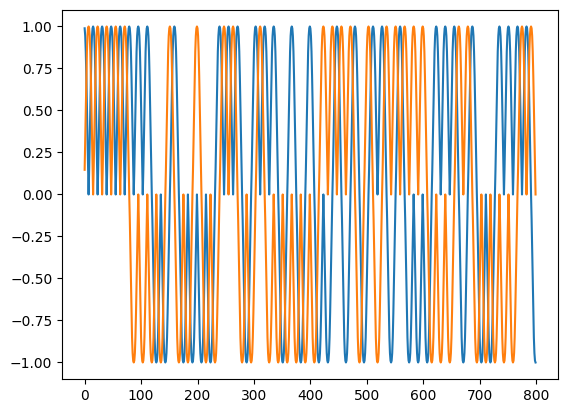

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)

idata=ReadSignalFromCsv('../DataProcessing/IDataTime.csv')[0][1]
qdata=-ReadSignalFromCsv('../DataProcessing/QDataTime.csv')[0][1]
print("idata shape: ", idata.shape)
print("qdata shape: ", qdata.shape)
plt.plot(idata)
plt.plot(qdata)
preamble_real = torch.tensor(idata.squeeze(), dtype=torch.float).to(device)
preamble_imag = torch.tensor(-qdata.squeeze(), dtype=torch.float).to(device)

print("preamble real: ", preamble_real.shape)
print("preamble imag: ", preamble_imag.shape)

matFiles=["pluto1_0.25meters_run2.mat",
"pluto2_0.25meters_run2.mat",
"pluto3_0.25meters_run2.mat",
"AD9082_0.25meters_run2.mat",
"AD9082_CC2595_amp1_0.25meters_run2.mat",
"TI_TRF3705_0.25meters.mat",
"TI_TRF3705_CC2595_amp1_0.25meters.mat",
"TI_TRF3722_CC2595_amp1_0.25meters.mat",
"TI_TRF3722_0.25meters.mat"]
datasets=[]
targets=[]
samples_perSDR=300
start=1
for SDRlabel in range(start, start+1):
    file = matFiles[SDRlabel]
    data=scipy.io.loadmat("./propossedData/0.25meters/"+file)['packet_equalized_allrecord']
    data = data[:samples_perSDR]
    for sigIdx in range(samples_perSDR):
        data[sigIdx]=-1+2*((data[sigIdx] - data[sigIdx].min())/(data[sigIdx].max() - data[sigIdx].min()))
    datasets.append(data)
    targets.append(SDRlabel*np.ones(samples_perSDR))

datasets=np.array(datasets).squeeze()
targets=np.array(targets).squeeze()
datasets=torch.tensor(datasets, dtype=float).to(device)
targets=torch.tensor(targets, dtype=torch.int64).to(device)
print("datasets: ", datasets.shape)
print("targets: ", targets.shape)
print("datasets range: ", datasets.max(), datasets.min())

input_dim=1
for i in range(1, len(datasets.shape)):
    input_dim=input_dim*datasets.shape[i]

output_dim=targets.shape[-1]
hidden_dim=256
latent_dim=2
LR =1e-2
n_epoch = 4000
batch_size = 32
N_harmonics = 1

rffDataset=Data.TensorDataset(datasets, targets)
rffTrain, rffVal, rffTest = Data.random_split(rffDataset, [0.6, 0.2, 0.2])
datasetLoader = Data.DataLoader(rffDataset, batch_size=1, shuffle=True, drop_last=True)
trainLoader = Data.DataLoader(rffTrain, batch_size=batch_size, shuffle=True, drop_last=True)
valLoader = Data.DataLoader(rffVal, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = Data.DataLoader(rffTest, batch_size=batch_size, shuffle=True, drop_last=True)
print("len trainLoader", len(trainLoader))
print("len valLoader", len(valLoader))
print("len testLoader", len(testLoader))

eng = matlab.engine.start_matlab()
generator = myMemPolyVAE(eng, preamble_real, preamble_imag, input_dim, hidden_dim, latent_dim, batch_size, device).to(device)

classifier = ClassifierSDR()
clf_load=torch.load("./checkpoint/ClassifierSDR/9SDR_0.25meters_normseperate1_epoch1000.cnn")
classifier=clf_load["classifier"]
train_acc=clf_load["train_acc"]
val_acc=clf_load["val_acc"]
test_acc=clf_load["test_acc"]

print("Load clf, train_acc:{:.2f}%, val_acc:{:.2f}%, test_acc:{:.2f}%".format(train_acc.item()*100, val_acc.item()*100, test_acc.item()*100))

criterion = torch.nn.BCELoss()

optimizer_g = torch.optim.Adam(generator.parameters(), lr = LR)

real_label = Variable(torch.ones(batch_size, 1), requires_grad=False).to(device)
fake_label = Variable(torch.zeros(batch_size, 1), requires_grad=False).to(device)
real_label_bool = Variable(torch.ones(batch_size, 1)>0, requires_grad=False).to(device)
fake_label_bool = Variable(torch.zeros(batch_size, 1)>0, requires_grad=False).to(device)

train_loss_curve_d=[]
train_loss_curve_g=[]
train_acc_curve=[]
train_acc_fake_curve=[]

val_loss_curve_d=[]
val_loss_curve_g=[]
val_acc_curve=[]
val_acc_fake_curve=[]

for epoch in range(n_epoch):
    # print("epoch: ", epoch)
    train_loss_d=0
    train_loss_g=0
    val_loss_d=0
    val_loss_g=0
    train_acc = []
    val_acc=[]
    train_acc_fake = []
    val_acc_fake=[]

    train_biacc = []
    val_biacc = []
    train_biacc_fake = []
    val_biacc_fake = []

    for batch_idx, (data, labels) in enumerate(trainLoader):
        # print("batch_idx: ", batch_idx)
        data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)

        # Train generator
        optimizer_g.zero_grad()
        fake_out_g, mu, logvar = generator.forward(data, device=device)
        fake_out_g = Variable(fake_out_g, requires_grad=True)

        labels_ = classifier.forward(data)
        labels_ = torch.argmax(labels_, dim=1)
        # train_acc+=(sum(labels_==labels)/batch_size)
        for i in range(batch_size):
            label=labels[i]
            train_acc.append(labels_[i]==label)

        labels_fake = classifier.forward(fake_out_g)
        labels_fake_arg = torch.argmax(labels_fake, dim=1)
        for i in range(batch_size):
            label=labels[i]
            train_acc_fake.append(labels_fake_arg[i]==label)

        loss_vae = generator.loss_function(fake_out_g, data, mu, logvar)
        loss_cnn = F.cross_entropy(labels_fake, labels)
        loss_g = loss_cnn #+ loss_cnn
        loss_g.backward()
        optimizer_g.step()
        train_loss_g+=loss_g.item()

    for batch_idx, (data, labels) in enumerate(valLoader):
        data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)

        # Fake data_hat given by generator
        data_fake, mu, logvar = generator.forward(data, device=device) 

        # Train generator
        fake_out_g, mu, logvar = generator.forward(data, device=device)
        fake_out_g = Variable(fake_out_g, requires_grad=True)

        labels_ = classifier.forward(data)
        labels_arg = torch.argmax(labels_, dim=1)
        # train_acc+=(sum(labels_==labels)/batch_size)
        for i in range(batch_size):
            label=labels[i]
            val_acc.append(labels_arg[i]==label)

        labels_fake = classifier.forward(fake_out_g)
        labels_fake = torch.argmax(labels_fake, dim=1)
        for i in range(batch_size):
            label=labels[i]
            val_acc_fake.append(labels_fake[i]==label)

        loss_vae = generator.loss_function(fake_out_g, data, mu, logvar)
        loss_cnn = F.cross_entropy(labels_, labels)
        loss_g = loss_cnn #+ loss_cnn
        val_loss_g+=loss_g.item()

    train_loss_d = train_loss_d/len(trainLoader)
    train_loss_g = train_loss_g/len(trainLoader)
    train_acc = sum(train_acc)/(len(train_acc))
    train_acc_fake = sum(train_acc_fake)/(len(train_acc_fake))
    

    val_loss_d = val_loss_d/len(valLoader)
    val_loss_g = val_loss_g/len(valLoader)
    val_acc = sum(val_acc)/(len(val_acc))
    val_acc_fake = sum(val_acc_fake)/(len(val_acc_fake))



    train_loss_curve_d.append(train_loss_d)
    train_loss_curve_g.append(train_loss_g)
    train_acc_curve.append(train_acc)
    train_acc_fake_curve.append(train_acc_fake)

    val_loss_curve_d.append(val_loss_d)
    val_loss_curve_g.append(val_loss_g)
    val_acc_curve.append(val_acc)
    val_acc_fake_curve.append(val_acc_fake)


    if (epoch+1) % 2 ==0:
        print('Training Epoch: {} \t GLoss: {:.3f}, DLoss: {:.3f}, ClfAcc: {:.3f}, ClfAcc(Fake): {:.3f}'.format(epoch+1, train_loss_g, train_loss_d, train_acc, train_acc_fake))
        print('Validation Epoch: {} \t GLoss: {:.3f}, DLoss: {:.3f}, ClfAcc: {:.3f}, ClfAcc(Fake): {:.3f}'.format(epoch+1, val_loss_g, val_loss_d, val_acc, val_acc_fake))

    if (epoch+1) % 500 ==0:
        checkpoint_path = "./code/ML/checkpoint/gan/polyVAE_SDR"+str(SDRlabel)+"_epoch"+str(epoch+1)+".gan"
        # torch.save({
        #         'epoch': epoch,
        #         'generator': generator,
        #         'classifier': classifier,
        #         'clfAcc_train':train_acc,
        #         'clfAccFake_train': train_acc_fake,
        #         'biAcc_train':train_biacc,
        #         'clfAcc_val':val_acc,
        #         'clfAccFake_val': val_acc_fake,
        #         'biAcc_val':val_biacc,
        #         }, checkpoint_path)

eng.quit()

tensor([-0.0258, -0.0764, -0.0344, -0.0367,  0.0332, -0.0472, -0.0721, -0.0632,
        -0.0129, -0.0137, -0.0080,  0.0518, -0.0456,  0.0372,  0.0248,  0.0185,
         0.0559,  0.0331, -0.0458, -0.0679,  0.0311,  0.0028,  0.0177, -0.0516,
         0.0179, -0.0487, -0.0209,  0.0305, -0.0173,  0.0550], device='cuda:0',
       grad_fn=<SelectBackward0>)


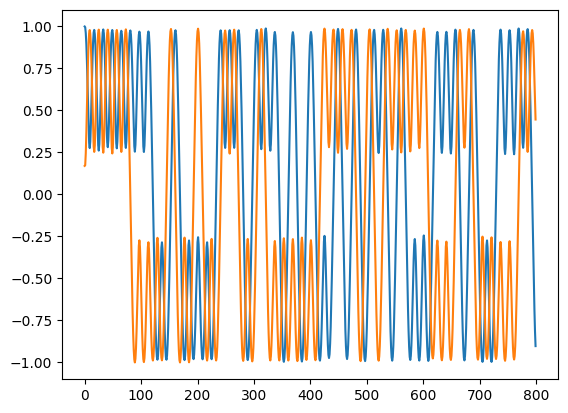

In [15]:
# fake_out_g=fake_out_g.detach().cpu().numpy()
plt.plot(fake_out_g[0][0])
plt.plot(fake_out_g[0][1])

# data=data.detach().cpu().numpy()
# plt.plot(data[0][0])
# plt.plot(data[0][1])

print(mu[0])